Our student exam numbers given for this exam 


In [79]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [80]:
def importCSV():
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    all_dfs = []

    for month in months:
        for year in range(2014, 2025):
            csv_string = f"Term paper/data/SCE-{month}-{year}.csv" 
            try:
                csv_file = pd.read_csv(csv_string, sep=";")
                all_dfs.append(csv_file)
            except FileNotFoundError:
                print(f"Filen {csv_string} finnes ikke.")

    return  pd.concat(all_dfs)
df = importCSV()

In [81]:
def df_stats(df):
    unique_persons = df["userid"].nunique()

    print(f"unique persons: {unique_persons}")
    print(f"number of rows: {df.shape[0]}")

    print(f"Number of unique survey waves: {df['wid'].nunique()}")

    earliest_date = df['date'].min()
    print(f"earliest_date: {earliest_date}")

    latest_date = df['date'].max()
    print(f"latest date: {latest_date}")

    return(df)

df_stats(df)


unique persons: 21666
number of rows: 165924
Number of unique survey waves: 132
earliest_date: 2014-01-02
latest date: 2024-12-31


,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q3,num_lit_q3_correct,num_lit_q5,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct
0,70016297,201401,2014-01-07,1.0,0.0,4.0,29.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70016329,201401,2014-01-02,4.5,1.0,2.0,43.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70016366,201401,2014-01-07,0.6,0.0,4.0,30.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70016375,201401,2014-01-16,0.7,1.0,4.0,28.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70016445,201401,2014-01-19,0.5,0.0,4.0,47.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,10.0,1.0,100.0,1.0,5.0,1.0,2.0,0.0,2.0,1.0
972,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,10.0,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0
973,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,10.0,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0
974,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,10.0,1.0,100.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0


Task 2

In [82]:


'''
# 0) Basic hygiene
df = df.copy()
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# --- Helpers for neat reporting ---
def sample_stats(_df, title="Sample stats"):
    n_obs = len(_df)
    n_indiv = _df["userid"].nunique() if "userid" in _df.columns else np.nan
    n_waves = _df["date"].dt.to_period("M").nunique() if "date" in _df.columns else np.nan
    dmin = _df["date"].min() if "date" in _df.columns else None
    dmax = _df["date"].max() if "date" in _df.columns else None
    print(f"\n== {title} ==")
    print(f"Observations: {n_obs:,}")
    print(f"Unique individuals: {n_indiv:,}" if pd.notna(n_indiv) else "Unique individuals: N/A")
    print(f"Survey waves (months): {n_waves:,}" if pd.notna(n_waves) else "Survey waves (months): N/A")
    if dmin is not None:
        print(f"Date range: {dmin.strftime('%Y-%m')} to {dmax.strftime('%Y-%m')}")

# Snapshot before cleaning
sample_stats(df, "Before cleaning")
'''

# 1) Forward-fill numeracy (per individual) from the first observation
#    The term paper says: forward-fill the *_correct variables only (asked at first entry).
num_cols = [c for c in df.columns if c.startswith("num_lit_") and c.endswith("_correct")]
if num_cols:
    first_vals = df.groupby("userid", dropna=False)[num_cols].transform("first")
    df[num_cols] = df[num_cols].fillna(first_vals)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165924 entries, 0 to 975
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userid              165924 non-null  int64  
 1   wid                 165924 non-null  int64  
 2   date                165924 non-null  object 
 3   weight              165873 non-null  float64
 4   female              165855 non-null  float64
 5   educ                165348 non-null  float64
 6   age                 165871 non-null  float64
 7   hispanic            165785 non-null  float64
 8   black               165918 non-null  float64
 9   couple              160170 non-null  float64
 10  num_kids            165924 non-null  float64
 11  owner               20419 non-null   float64
 12  inflation           165321 non-null  float64
 13  house_price_change  165662 non-null  float64
 14  prob_stocks_up      165676 non-null  float64
 15  num_lit_q1          20423 non-null   float

In [83]:
 #2) Drop rows with missing required fields
#    Demographics: female (indicator), age, educ
#    Expectations: inflation, house_price_change, prob_stocks_up
#    Numeracy: all *_correct columns (after forward fill)
required_cols = ["female", "age", "educ", "inflation", "house_price_change", "prob_stocks_up"] + num_cols
required_cols = [c for c in required_cols if c in df.columns]  # keep only those that exist

before = len(df)
df = df.dropna(subset=required_cols)
dropped_missing = before - len(df)
print(f"\nDropped rows with missing required values: {dropped_missing:,}")



Dropped rows with missing required values: 28,348


In [84]:
#3) Drop outliers using 0.1th and 99.9th percentiles for each expectations variable
exp_vars = [c for c in ["inflation", "house_price_change", "prob_stocks_up"] if c in df.columns]
dropped_outliers_total = 0
for col in exp_vars:
    q_low = df[col].quantile(0.001)
    q_high = df[col].quantile(0.999)
    mask_keep = (df[col] >= q_low) & (df[col] <= q_high)
    dropped = (~mask_keep).sum()
    df = df.loc[mask_keep].copy()
    dropped_outliers_total += int(dropped)
    print(f"Dropped outliers for {col}: {int(dropped):,} "
          f"(kept [{q_low:.3f}, {q_high:.3f}])")

print(f"Total outliers dropped: {dropped_outliers_total:,}")


Dropped outliers for inflation: 119 (kept [-75.000, 100.000])
Dropped outliers for house_price_change: 179 (kept [-50.000, 100.000])
Dropped outliers for prob_stocks_up: 0 (kept [0.000, 100.000])
Total outliers dropped: 298


In [85]:
# 4) Create 'college' = 1 if educ >= 4 (Bachelor’s or higher), else 0
#    (educ is ordinal: 1=no HS/GED, 2=HS/GED, 3=some college/assoc., 4=bachelor’s+)
if "educ" in df.columns:
    df["college"] = (df["educ"] >= 4).astype(int)

df


,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q3_correct,num_lit_q5,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct,college
114,70057321,201601,2016-01-23,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
117,70057352,201601,2016-01-19,1.1,0.0,4.0,38.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
118,70057367,201601,2016-01-05,0.6,0.0,4.0,65.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
120,70057373,201601,2016-01-13,0.7,0.0,4.0,51.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
121,70057405,201601,2016-01-09,0.5,1.0,4.0,64.0,0.0,0.0,0.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,1.0,100.0,1.0,5.0,1.0,2.0,0.0,2.0,1.0,0
972,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,1
973,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,0
974,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,1.0,100.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0,0


In [86]:
# 5) Sum correct numeracy answers per row and create 'num_lit_high'
def num_correct_stats(df, num_cols):
    # Get unique users only once
    df_unique = df.loc[~df['userid'].duplicated()]
    unique_users = df_unique.shape[0]
    
    if num_cols:
        # Sum correct answers per row
        df["num_correct"] = df[num_cols].sum(axis=1)
        # Calculate and print percentage for each possible score
        counts = df_unique["num_correct"].value_counts().sort_index()
        for score, count in counts.items():
            percent = count / unique_users
            print(f"{percent:.2%} have {score} correct answers")
        # Median for "high numeracy"
        med = df["num_correct"].median()
        df["num_lit_high"] = (df["num_correct"] > med).astype(int)
    else:
        med = None

    return df, med

# Call the function and update df / med locally
df, med = num_correct_stats(df, num_cols)
df



KeyError: 'num_correct'

In [ ]:
# 6) Final sample stats (same structure as Part 1)
df_stats(df)

unique persons: 17701
number of rows: 137278
Number of unique survey waves: 117
earliest_date: 2015-04-02
latest date: 2024-12-31


,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct,college,num_correct,num_lit_high
114,70057321,201601,2016-01-23,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0,1
117,70057352,201601,2016-01-19,1.1,0.0,4.0,38.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0,1
118,70057367,201601,2016-01-05,0.6,0.0,4.0,65.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0,1
120,70057373,201601,2016-01-13,0.7,0.0,4.0,51.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0,1
121,70057405,201601,2016-01-09,0.5,1.0,4.0,64.0,0.0,0.0,0.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,1.0,5.0,1.0,2.0,0.0,2.0,1.0,0,5.0,0
972,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,1.0,5.0,1.0,3.0,1.0,2.0,1.0,1,6.0,0
973,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,1.0,5.0,1.0,3.0,1.0,2.0,1.0,0,7.0,1
974,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,1.0,1.0,0.0,3.0,1.0,2.0,1.0,0,5.0,0


# Part 3 — Average expectations by group
## structure: 

3.0 general function 

3.1 Males vs. females

3.2 Non-college vs. college

3.3 Low vs. high numeracy


## general function 


In [ ]:
def GroupIndex(df, GroupCol): 
    df1 = df.groupby(GroupCol)[["inflation", "house_price_change", "prob_stocks_up"]].mean().reset_index()
    df1 = df1.set_index(GroupCol)
    return df1


In [88]:
def BarChart(df, label1, label2): 
    # Choose the elements
    ColNames = list(df1.columns)

    # number of element on the Xaxis
    NumCol = len(df1.columns)
    x = np.arange(NumCol)
    width = 0.35

    # making bars for men and women (Men = 0, women = 1)
     # Get values for each group
    vals1 = df.loc[0, ColNames].squeeze()  # = 0
    vals2 = df.loc[1, ColNames].squeeze()  # = 1

    plt.bar(x - width/2, vals1, width, label=label1)
    plt.bar(x + width/2, vals2, width, label=label2)

    # Estetics 
    plt.xticks(x, ColNames)
    plt.ylabel("Values")
    plt.title("Comparison by Gender")
    plt.legend()



    plt.show()




### 3.1 Males vs. females

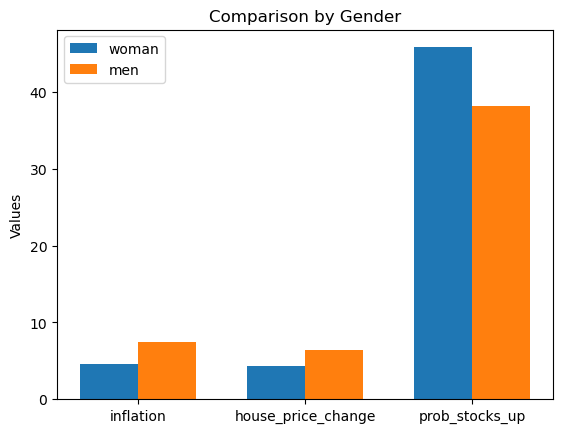

In [89]:
df1 = GroupIndex(df, "female")
BarChart(df1, "woman", "men")

### 3.2 Non-college vs. college


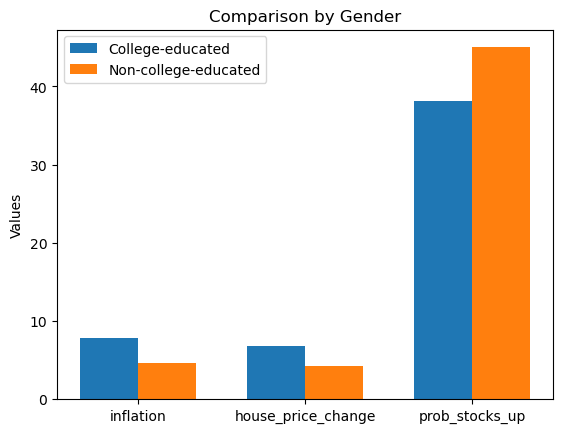

In [94]:
df2 = GroupIndex(df, "college")
BarChart(df2, "College-educated", "Non-college-educated")

### 3.3  Low vs. high numeracy


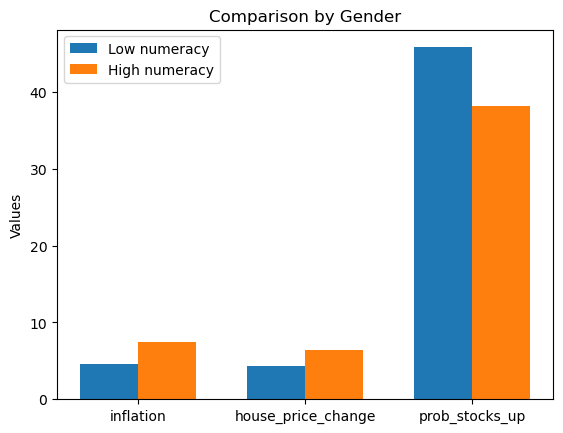

In [95]:
df3 = GroupIndex(df, "female")
BarChart(df3, "Low numeracy", "High numeracy")